**Face Recognition using Siamese Networks with Meta Learning** 

The goal of this face recognition model is to understand whether the given two face images are same or different.

Dataset used: [AT&T Database of Faces](https://www.kaggle.com/kasikrit/att-database-of-faces)

In [8]:
# Import required libraries

import re
import keras
import numpy as np
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [9]:
#Function to read the images from dataset and convert them to a Numpy array

def readImage(fileName, byteOrder='>'):
    
    # Read the image
    with open(fileName, 'rb') as f:
        buffer = f.read()
    
    # Extract header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    # Convert the image to a Numpy array
    img_to_nmpy = np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteOrder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
    return img_to_nmpy

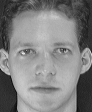

In [10]:
#Check the sample image
Image.open("/content/drive/My Drive/Data/archive/s1/1.pgm")

In [11]:
# Using readImage function read the image from dataset and convert it to a Numpy array

img = readImage('/content/drive/My Drive/Data/archive/s1/1.pgm')

In [12]:
# Check the shape of an retrieved image
img.shape

(112, 92)

In [17]:
# Generate the data. 

size = 2
totalSampleSize = 10000


def getData(size, totalSampleSize):
    img = readImage('/content/drive/My Drive/Data/archive/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    img = img[::size, ::size]
    dim1 = img.shape[0]
    dim2 = img.shape[1]
    count = 0

    #initialize the numpy array
    xGenuinePair = np.zeros([totalSampleSize, 2, 1, dim1, dim2]) 
    yGenuine = np.zeros([totalSampleSize, 1])
    
    for i in range(30):
        for j in range(int(totalSampleSize/30)):
            ind_1 = 0
            ind_2 = 0
            while ind_1 == ind_2:
                ind_1 = np.random.randint(10)
                ind_2 = np.random.randint(10)
            
            # Read the images
            img_1 = readImage('/content/drive/My Drive/Data/archive/s' + str(i+1) + '/' + str(ind_1 + 1) + '.pgm', 'rw+')
            img_2 = readImage('/content/drive/My Drive/Data/archive/s' + str(i+1) + '/' + str(ind_2 + 1) + '.pgm', 'rw+')
            
            # Resize the images
            img_1 = img_1[::size, ::size]
            img_2 = img_2[::size, ::size]
            
            # Store the images to the numpy array
            xGenuinePair[count, 0, 0, :, :] = img_1
            xGenuinePair[count, 1, 0, :, :] = img_2
            
            # Assign label 1 to the genuine images
            yGenuine[count] = 1
            count += 1

    # Repeat the same process fro imposite images
    count = 0
    xImpositePair = np.zeros([totalSampleSize, 2, 1, dim1, dim2])
    yImposite = np.zeros([totalSampleSize, 1])
    
    for i in range(int(totalSampleSize/10)):
        for j in range(10):
            while True:
                ind_1 = np.random.randint(40)
                ind_2 = np.random.randint(40)
                if ind_1 != ind_2:
                    break
                    
            img_1 = readImage('/content/drive/My Drive/Data/archive/s' + str(ind_1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img_2 = readImage('/content/drive/My Drive/Data/archive/s' + str(ind_2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img_1 = img_1[::size, ::size]
            img_2 = img_2[::size, ::size]

            xImpositePair[count, 0, 0, :, :] = img_1
            xImpositePair[count, 1, 0, :, :] = img_2

            # Assign label 0 to imposite pair of images
            yImposite[count] = 0
            count += 1
            
    # Concatenate the genuine pairs and imposite pair to get the whole data
    X = np.concatenate([xGenuinePair, xImpositePair], axis=0)/255
    Y = np.concatenate([yGenuine, yImposite], axis=0)

    return X, Y

In [18]:
# Generate the data and store in X and Y variables

X, Y = getData(size, totalSampleSize)

In [19]:
# Check the shape of input images
X.shape

(20000, 2, 1, 56, 46)

In [20]:
# Check the shape of Y
Y.shape

(20000, 1)

In [21]:
# Split the data to train and test

xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=.30)

In [22]:
# Build the Siamese Network with 2 layer Convolutional network as a base network which would be used for feature extraction from images

def buildBaseNetwork(inputShape):
    
    seq = Sequential()
    nb_filter = [6, 12]
    kernelSize = 3
    
    # Conv layer 1
    seq.add(Convolution2D(nb_filter[0], kernelSize, kernelSize, input_shape=inputShape,
                          padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    # Conv layer 2
    seq.add(Convolution2D(nb_filter[1], kernelSize, kernelSize, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) 
    seq.add(Dropout(.25))

    # Flatten the layers
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [24]:
# Image pair to feed to the base network to get the feature vectors

input_Dim = xTrain.shape[2:]
img_A = Input(shape=input_Dim)
img_B = Input(shape=input_Dim)

In [25]:
base_network = buildBaseNetwork(input_Dim)
feat_vecs_A = base_network(img_A)
feat_vecs_B = base_network(img_B)

In [26]:
# Fuunctions to determine the distancce between the feature vectors

def euclideanDistance(vects):
    x, y = vects
    dist = K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
    return dist


def euclDistOutputShape(shapes):
    shape1, shape2 = shapes
    eu_dist_op_shape = (shape1[0], 1)
    return eu_dist_op_shape

In [28]:
distance = Lambda(euclideanDistance, output_shape=euclDistOutputShape)([feat_vecs_A, feat_vecs_B])

In [41]:
# Define number of epochs and optimization function to be used
epochs = 30
rms = RMSprop()

In [42]:
# Define the model
model = Model([img_A, img_B],distance)

In [43]:
# Loss function

def contrastiveLoss(yTrue, yPred):
    margin = 1
    loss = K.mean(yTrue * K.square(yPred) + (1 - yTrue) * K.square(K.maximum(margin - yPred, 0)))
    return loss

In [44]:
# Compile the model

model.compile(loss=contrastiveLoss, optimizer=rms)

In [45]:
img_1 = xTrain[:, 0]
img_2 = xTrain[:, 1]

In [46]:
# Train the model

model.fit([img_1, img_2], yTrain, validation_split=.25,
          batch_size=128, verbose=2, epochs=epochs)

Epoch 1/30
83/83 - 1s - loss: 0.1614 - val_loss: 0.1278
Epoch 2/30
83/83 - 0s - loss: 0.1583 - val_loss: 0.1281
Epoch 3/30
83/83 - 0s - loss: 0.1522 - val_loss: 0.1159
Epoch 4/30
83/83 - 0s - loss: 0.1510 - val_loss: 0.1244
Epoch 5/30
83/83 - 0s - loss: 0.1472 - val_loss: 0.1497
Epoch 6/30
83/83 - 1s - loss: 0.1448 - val_loss: 0.1243
Epoch 7/30
83/83 - 1s - loss: 0.1421 - val_loss: 0.1060
Epoch 8/30
83/83 - 0s - loss: 0.1405 - val_loss: 0.1154
Epoch 9/30
83/83 - 0s - loss: 0.1368 - val_loss: 0.1248
Epoch 10/30
83/83 - 0s - loss: 0.1349 - val_loss: 0.1146
Epoch 11/30
83/83 - 0s - loss: 0.1335 - val_loss: 0.1043
Epoch 12/30
83/83 - 1s - loss: 0.1324 - val_loss: 0.1053
Epoch 13/30
83/83 - 1s - loss: 0.1310 - val_loss: 0.0961
Epoch 14/30
83/83 - 0s - loss: 0.1308 - val_loss: 0.0950
Epoch 15/30
83/83 - 0s - loss: 0.1296 - val_loss: 0.0977
Epoch 16/30
83/83 - 0s - loss: 0.1288 - val_loss: 0.0968
Epoch 17/30
83/83 - 0s - loss: 0.1272 - val_loss: 0.0885
Epoch 18/30
83/83 - 0s - loss: 0.1256 - 

In [47]:
# Make predictions

pred = model.predict([xTest[:, 0], xTest[:, 1]])

In [48]:
# Function to determine accuracy of model
def computeAccuracy(predictions, labels):
    accuracy = labels[predictions.ravel() < 0.5].mean()
    return accuracy

In [49]:
# Check accuracy of the model
computeAccuracy(pred, yTest)

0.828646748681898